### Import Statements

In [1]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

In [2]:
from Bio import SeqIO


### Set matplotlib text export settings for Adobe Illustrator

In [3]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#### Pandas Viewing Settings

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
#from panqc.utils import parse_PresAbs_Rtab, parse_PresAbs_CSV_Roary, parse_PresAbs_CSV_Panaroo, get_PG_Stats_FromPresAbs
from panqc.utils import get_PG_Stats_FromPresAbs


In [6]:
def parse_PresAbs_Rtab_V2(PresAbs_Rtab_PATH):
    '''
    This function parsesthe `gene_presence_absence.csv` file output by Panaroo '''

    i_Gene_PresAbs_DF = pd.read_csv(PresAbs_Rtab_PATH, sep = "\t")

    ### Relabel Columns for presence/absence tracking
    i_Gene_PresAbs_DF.columns = [ x.split(".CDHIT")[0] for x in i_Gene_PresAbs_DF.columns ]


    ListOf_SampleID_Cols = list(i_Gene_PresAbs_DF.drop(["Gene"], axis=1).columns)
    
    i_Gene_PresAbs_DF["NumAsm_WiGene"] = i_Gene_PresAbs_DF[ListOf_SampleID_Cols].sum(axis = 1)

    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.sort_values(by='NumAsm_WiGene', ascending=False)
    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.set_index("Gene", drop=False)

    return i_Gene_PresAbs_DF

In [7]:
def infer_PG_Stats_FromRtab(i_Pangene_Rtab, i_NumSamples, verbose = False):

    Pangene_Rtab_DF = parse_PresAbs_Rtab_V2(i_Pangene_Rtab)

    NumTotalGenes, NumCoreGenes, NumAccessoryGenes = get_PG_Stats_FromPresAbs(Pangene_Rtab_DF, i_NumSamples)

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    Pangene_PG_Stats_DF = pd.DataFrame(listOf_PG_Rows)
    Pangene_PG_Stats_DF.columns = ["Category", "Range", "GeneCount"]
    
    return Pangene_PG_Stats_DF

In [8]:

def read_PanarooSummaryStats(input_Panaroo_SummaryStats_TXT):
    
    i_Panaroo_Stats_DF = pd.read_csv(input_Panaroo_SummaryStats_TXT, sep = "\t", header=None)
    i_Panaroo_Stats_DF.columns = ["Category", "Range", "GeneCount"]

    Acc_GenesCount = i_Panaroo_Stats_DF["GeneCount"].values[-1] - i_Panaroo_Stats_DF["GeneCount"].values[0]

    i_Panaroo_AccGenesRow = ["Accessory genes","(0% <= strains < 99%)", Acc_GenesCount]

    i_Panaroo_Stats_DF.loc[len(i_Panaroo_Stats_DF.index)] = i_Panaroo_AccGenesRow

    #listOfCat_ToKeep = ["Core genes", "Accessory Genes", "Total genes"]

    i_Panaroo_Stats_DF = i_Panaroo_Stats_DF[ i_Panaroo_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

    # https://www.statology.org/pandas-add-row-to-dataframe/#:~:text=You%20can%20use%20the%20df,loc%5Blen(df. 

    return i_Panaroo_Stats_DF

In [9]:
def read_Ppanggolin_ContextStats(i_Ppanggolin_Content_TXT, verbose = False):
    if verbose:
        print(f"reading Ppangolin stats from {i_Ppanggolin_Content_TXT}")
        
    with open(i_Ppanggolin_Content_TXT, "r") as f:

        #NumCoreGenes = -1
        #NumShellGenes = -1
        #NumCloudGenes = -1
        for line in f:
            #print(line)
            line_split = line.split(": ")

            Key = line_split[0].split(" ")[0]
            Value = line_split[-1].strip()

            if Key == "Persistent": NumCoreGenes = int(Value)
            elif Key == "Shell": NumShellGenes = int(Value)
            elif Key == "Cloud": NumCloudGenes = int(Value)
        print(NumShellGenes, NumCloudGenes)
        NumAccessoryGenes = NumShellGenes + NumCloudGenes
        NumTotalGenes = NumCoreGenes + NumAccessoryGenes

        #print(NumCoreGenes, NumAccessoryGenes, NumTotalGenes)

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    PPanggolin_Summary_DF = pd.DataFrame(listOf_PG_Rows)
    PPanggolin_Summary_DF.columns = ["Category", "Range", "GeneCount"]
    
    return PPanggolin_Summary_DF

# Parse sample metadata & preprocessed genome info/results

## Parse sample Metadata (N = 151)

In [10]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [11]:
# Define pipeline output directories

WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

#MtbWGA_SMK_Pipeline_OutputDir = WGA_SMK_Outputs_Dir + "/220427_WGA158CI_V1"
WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"
Mtb_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir

In [12]:
target_OutputDir = Mtb_SMK_Pipeline_OutputDir


i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"

i_Pangene_OutDir = f"{i_Pangenome_Dir}/Pangene"


In [13]:
!ls -1 $i_Pangenome_Dir/Pangene | head -n 20

CD-HIT_Clustering_Bakta
CD-HIT_Clustering_PGAP
Miniprot
Mtb151CI.Bakta.AllCDSMerged.faa
Mtb151CI.PGAP.AllCDSMerged.faa
Mtb151CI.SRAsms.Bakta.AllCDSMerged.faa
Mtb151CI.SRAsms.PGAP.AllCDSMerged.faa
Pangene_0.95.Miniprot0.95_AllIsolates
Pangene_0.95.Miniprot0.95_AllIsolates_WiPGAPAnno_V1
Pangene_0.95.Miniprot0.98_AllIsolates
Pangene_0.95.Miniprot0.98_AllIsolates_WiPGAPAnno_V1
Pangene_0.95.Miniprot0.99_AllIsolates
Pangene_0.95.Miniprot0.99_AllIsolates_WiPGAPAnno_V1
Pangene_0.95.Miniprot0.9_AllIsolates
Pangene_0.95.Miniprot0.9_AllIsolates_WiPGAPAnno_V1
Pangene_0.98.Miniprot0.95_AllIsolates
Pangene_0.98.Miniprot0.95_AllIsolates_WiPGAPAnno_V1
Pangene_0.98.Miniprot0.98_AllIsolates
Pangene_0.98.Miniprot0.98_AllIsolates_WiPGAPAnno_V1
Pangene_0.98.Miniprot0.99_AllIsolates
ls: write error: Broken pipe


In [14]:
!ls -1 $i_Pangenome_Dir/Pangene_0.95.Miniprot0.95_AllIsolates | head -n 10

gene_presence_absence.Renamed.Rtab
Panstripe_PhyloAnalysis


In [15]:
!ls -1 $i_Pangenome_Dir/Pangene_0.95.Miniprot0.95_AllIsolates/Panstripe_PhyloAnalysis

Panstripe.ACE.Events.GeneGain.tsv
Panstripe.ACE.Events.GeneLoss.tsv
Panstripe.BranchStats.tsv
Panstripe.cumulativeplot.png
Panstripe.gene.gainloss.sidebyside.plot.png
Panstripe.gene.gainloss.sidebyside.plot.svg
Panstripe.PanstripeSummary.tsv
Panstripe.paramplot.png


In [16]:
Mtb_LR_Pangene_C90M90_Rtab = f"{i_Pangene_OutDir}/Pangene_0.98.Miniprot0.99_AllIsolates/Mtb151CI.Pangene_0.98.Miniprot0.99.gene_presence_absence.Rtab"    
!ls -lah $Mtb_LR_Pangene_C90M90_Rtab

-rw-rw-r-- 1 mm774 farhat 1.3M Nov 22 11:09 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Pangene/Pangene_0.98.Miniprot0.99_AllIsolates/Mtb151CI.Pangene_0.98.Miniprot0.99.gene_presence_absence.Rtab


In [17]:
!ls -1 $i_Pangenome_Dir/Pangene/Pangene_0.98.Miniprot0.99_AllIsolates/

Mtb151CI.Pangene_0.98.Miniprot0.99.gene_presence_absence.Rtab
Mtb151CI.Pangene_0.98.Miniprot0.99.gfa


In [18]:

def calculate_gene_gain_loss_stats(branchstats_tsv):
    """
    Calculate gene gain and loss statistics for ancestral branches and tips
    from a branchstats.tsv file generated by Panstripe software.
    
    Parameters:
        branchstats_tsv (str): Path to the branchstats.tsv file.
        
    Returns:
        dict: A dictionary containing the four statistics:
              - N_Gain_AncBranches: Total number of genes gained on ancestral branches.
              - N_Loss_AncBranches: Total number of genes lost on ancestral branches.
              - N_Gain_Tips: Total number of genes gained on tips.
              - N_Loss_Tips: Total number of genes lost on tips.
    """
    # Load the data
    data = pd.read_csv(branchstats_tsv, sep="\t")
    
    # Split the data into ancestral branches and tips
    data_tips = data.query("istip == 1")
    data_ancs = data.query("istip == 0")
    
    # Calculate statistics
    stats = {
        "N_Gain_Ancs": data_ancs["acc_gain"].sum(),
        "N_Loss_Ancs": data_ancs["acc_loss"].sum(),
        "N_Gain_Tips": data_tips["acc_gain"].sum(),
        "N_Loss_Tips": data_tips["acc_loss"].sum()
    }
    
    return stats

# Example usage:
# file_path = "path/to/Panstripe.BranchStats.tsv"
# stats = calculate_gene_gain_loss_stats(file_path)
# print(stats)


In [19]:
LR_Pangene_C90M90_Panstripe_Summ_TSV   = f"{i_Pangenome_Dir}/Pangene_0.98.Miniprot0.99_AllIsolates/Panstripe_PhyloAnalysis/Panstripe.PanstripeSummary.tsv"    

LR_Pangene_C90M90_Panstripe_Branch_TSV = f"{i_Pangenome_Dir}/Pangene_0.98.Miniprot0.99_AllIsolates/Panstripe_PhyloAnalysis/Panstripe.BranchStats.tsv"    

!ls -lah $LR_Pangene_C90M90_Panstripe_Summ_TSV
!ls -lah $LR_Pangene_C90M90_Panstripe_Branch_TSV


-rw-rw-r-- 1 mm774 farhat 540 Nov 22 11:14 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Pangene_0.98.Miniprot0.99_AllIsolates/Panstripe_PhyloAnalysis/Panstripe.PanstripeSummary.tsv
-rw-rw-r-- 1 mm774 farhat 18K Nov 22 11:14 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Pangene_0.98.Miniprot0.99_AllIsolates/Panstripe_PhyloAnalysis/Panstripe.BranchStats.tsv


In [20]:
calculate_gene_gain_loss_stats(LR_Pangene_C90M90_Panstripe_Branch_TSV)

{'N_Gain_Ancs': 217,
 'N_Loss_Ancs': 513,
 'N_Gain_Tips': 420,
 'N_Loss_Tips': 741}

In [21]:
pd.read_csv(LR_Pangene_C90M90_Panstripe_Summ_TSV, sep = "\t")

,term,estimate,std.error,statistic,p.value,bootstrap CI 2.5%,bootstrap CI 97.5%
0,istip,0.641117,0.171659,3.734819,2.253123e-04,0.17751,1.0933
1,core,1634.481862,88.160428,18.539859,1.834835e-51,1390.10000,2725.2000
2,depth,211.488449,32.737613,6.460106,4.290309e-10,102.01000,272.5000
3,istip:core,-588.283077,128.044757,-4.594355,6.431699e-06,-1534.40000,145.6900
4,p,1.345421,NaN,NaN,NaN,1.26630,1.3933
5,phi,3.947731,NaN,NaN,NaN,3.36130,4.4313


In [22]:
D = pd.read_csv(LR_Pangene_C90M90_Panstripe_Branch_TSV, sep = "\t")
D.shape

(300, 11)

In [23]:
D_Tips = D.query("istip == 1")
D_Anc  = D.query("istip == 0")

N_Gain_AncBranches = D_Anc["acc_gain"].sum()
N_Loss_AncBranches = D_Anc["acc_loss"].sum()

N_Gain_Tips = D_Tips["acc_gain"].sum()
N_Loss_Tips = D_Tips["acc_loss"].sum()


In [24]:
N_Gain_AncBranches

217

In [25]:
N_Loss_AncBranches

513

In [26]:
N_Gain_Tips

420

In [27]:
N_Loss_Tips

741

In [28]:
D_Tips.shape

(151, 11)

In [29]:
D_Anc.shape

(149, 11)

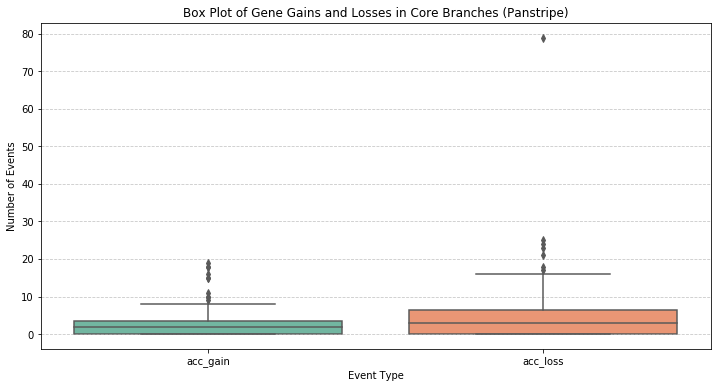

In [30]:
# Plot Panstripe dataset as a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=D_Tips[['acc_gain', 'acc_loss']].melt(var_name='Event Type', value_name='Count'), 
            x='Event Type', y='Count', palette='Set2')

plt.title('Box Plot of Gene Gains and Losses in Core Branches (Panstripe)')

plt.ylabel('Number of Events')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

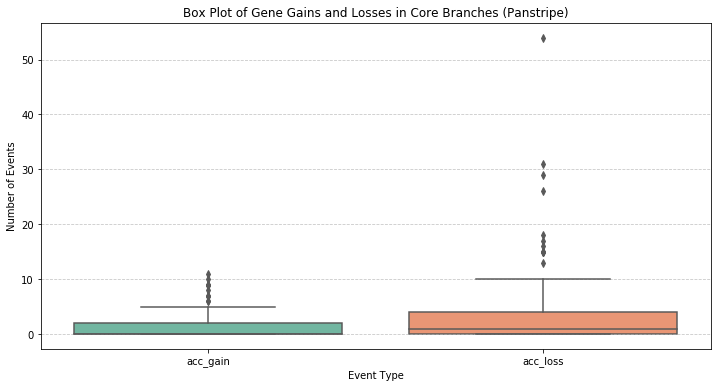

In [31]:
# Plot Panstripe dataset as a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=D_Anc[['acc_gain', 'acc_loss']].melt(var_name='Event Type', value_name='Count'), 
            x='Event Type', y='Count', palette='Set2')

plt.title('Box Plot of Gene Gains and Losses in Core Branches (Panstripe)')

plt.ylabel('Number of Events')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [32]:
!ls -1 $i_Pangene_OutDir/Pangene_0.95.Miniprot0.95_AllIsolates | grep Rtab

Mtb151CI.Pangene_0.95.Miniprot0.95.gene_presence_absence.Rtab


In [33]:
Pangene_C90M90_PA = parse_PresAbs_Rtab_V2(Mtb_LR_Pangene_C90M90_Rtab)
Pangene_C90M90_PA.shape

(4245, 153)

In [34]:
N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs(Pangene_C90M90_PA, 151)
print(N_Total, N_Core, N_Acc)

Accessory Thresh: 149.49
4245 3792 453


In [35]:
#!ls -1 $i_Pangenome_Dir

In [36]:
!ls -1 $i_Pangene_OutDir | grep Rtab

# Define output files & parse results for each pipeline

In [37]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',
                         "Ppanggolin_I0.80C0.60",
                         "Ppanggolin_I0.80C0.80",
                         "Ppanggolin_I0.80C0.90",
                         "Ppanggolin_I0.90C0.60",
                         "Ppanggolin_I0.90C0.80",
                         "Ppanggolin_I0.90C0.90",
                         "Ppanggolin_I0.98C0.60",
                         "Ppanggolin_I0.98C0.80",
                         "Ppanggolin_I0.98C0.90",
                         'Pangene_0.9.Miniprot0.95',
                         'Pangene_0.9.Miniprot0.98',
                         'Pangene_0.9.Miniprot0.99',
                         'Pangene_0.9.Miniprot0.9',
                         'Pangene_0.95.Miniprot0.95',
                         'Pangene_0.95.Miniprot0.98',
                         'Pangene_0.95.Miniprot0.99',
                         'Pangene_0.95.Miniprot0.9',
                         'Pangene_0.98.Miniprot0.95',
                         'Pangene_0.98.Miniprot0.98',
                         'Pangene_0.98.Miniprot0.99',
                         'Pangene_0.98.Miniprot0.9',] 


target_OutputDir = Mtb_SMK_Pipeline_OutputDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"

listOfCat_ToKeep = ["Core genes", "Accessory genes", "Total genes"]


dictOf_PG_OutInfo = {}
dictOf_PG_PresAbs_DF = {}
dictOf_PG_OutDir_PATHs = {}

for i_SampleSet in ["All"]:
    
    dictOf_PG_OutInfo[i_SampleSet] = {}
    dictOf_PG_OutDir_PATHs[i_SampleSet] = {}
    dictOf_PG_PresAbs_DF[i_SampleSet] = {}
    
    for AnnoPipeline in ["Bakta", "PGAP"]:
        
        dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline] = {}
        
        for AsmTech in ["LongRead", "ShortRead"]:       
            
            dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech] = {}
            
            
            for i_PipeNameWiParam in tqdm(PipeName_WiParam_List):
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = {}
                                
                if i_SampleSet == "All": DataSetSuffix = "_AllIsolates"  

                if AsmTech == "LongRead": SeqTechPrefix = ""
                elif AsmTech == "ShortRead": SeqTechPrefix = "SR_"

                if AnnoPipeline == "Bakta": AnnoSuffix = ""
                elif AnnoPipeline == "PGAP": AnnoSuffix = "_WiPGAPAnno_V1"


                i_Pipeline_OutDir = f"{i_Pangenome_Dir}/{SeqTechPrefix}{i_PipeNameWiParam}{DataSetSuffix}{AnnoSuffix}"

                i_Pangene_OutDir  = f"{i_Pangenome_Dir}/Pangene/{SeqTechPrefix}{i_PipeNameWiParam}{DataSetSuffix}{AnnoSuffix}"
                
                if "Pangene" in i_PipeNameWiParam:
                    
                    Pangene_ParamString = i_PipeNameWiParam[8:]
                    # i_PipeNameWiParam
                    print(Pangene_ParamString)
                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pangene_OutDir}/Mtb151CI.{i_PipeNameWiParam}.gene_presence_absence.Rtab"    

                    i_PG_Stats_DF = infer_PG_Stats_FromRtab(i_Gene_PresAbs_Rtab_PATH, 151)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    
                    i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis/Panstripe.BranchStats.tsv"    

                    GainLoss_Stats = calculate_gene_gain_loss_stats(i_Panstripe_BranchStats_TSV_PATH)
                    i_PG_Stats_DF["N_Gain_Ancs"] = GainLoss_Stats["N_Gain_Ancs"]
                    i_PG_Stats_DF["N_Loss_Ancs"] = GainLoss_Stats["N_Loss_Ancs"]
                    i_PG_Stats_DF["N_Gain_Tips"] = GainLoss_Stats["N_Gain_Tips"]
                    i_PG_Stats_DF["N_Loss_Tips"] = GainLoss_Stats["N_Loss_Tips"]

              
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_Rtab"] = i_Gene_PresAbs_Rtab_PATH
                
                
                if "Panaroo" in i_PipeNameWiParam:
                    
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    
                    i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis/Panstripe.BranchStats.tsv"    

                    GainLoss_Stats = calculate_gene_gain_loss_stats(i_Panstripe_BranchStats_TSV_PATH)
                    i_PG_Stats_DF["N_Gain_Ancs"] = GainLoss_Stats["N_Gain_Ancs"]
                    i_PG_Stats_DF["N_Loss_Ancs"] = GainLoss_Stats["N_Loss_Ancs"]
                    i_PG_Stats_DF["N_Gain_Tips"] = GainLoss_Stats["N_Gain_Tips"]
                    i_PG_Stats_DF["N_Loss_Tips"] = GainLoss_Stats["N_Loss_Tips"]

                    
                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    
                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"
                    
                    #i_Gene_PresAbs_DF = parse_Panaroo_GenePresAbs_CSV(i_Gene_PresAbs_CSV_PATH)  

                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH


                elif "Roary" in i_PipeNameWiParam:
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis/Panstripe.BranchStats.tsv"    

                    GainLoss_Stats = calculate_gene_gain_loss_stats(i_Panstripe_BranchStats_TSV_PATH)
                    i_PG_Stats_DF["N_Gain_Ancs"] = GainLoss_Stats["N_Gain_Ancs"]
                    i_PG_Stats_DF["N_Loss_Ancs"] = GainLoss_Stats["N_Loss_Ancs"]
                    i_PG_Stats_DF["N_Gain_Tips"] = GainLoss_Stats["N_Gain_Tips"]
                    i_PG_Stats_DF["N_Loss_Tips"] = GainLoss_Stats["N_Loss_Tips"]

                    
                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    

                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"
                    
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH

                elif "Ppanggolin" in i_PipeNameWiParam:

                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.Rtab"    

                    i_PG_Stats_DF = infer_PG_Stats_FromRtab(i_Gene_PresAbs_Rtab_PATH, 151)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                                        
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)


                    i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis/Panstripe.BranchStats.tsv"    

                    GainLoss_Stats = calculate_gene_gain_loss_stats(i_Panstripe_BranchStats_TSV_PATH)
                    i_PG_Stats_DF["N_Gain_Ancs"] = GainLoss_Stats["N_Gain_Ancs"]
                    i_PG_Stats_DF["N_Loss_Ancs"] = GainLoss_Stats["N_Loss_Ancs"]
                    i_PG_Stats_DF["N_Gain_Tips"] = GainLoss_Stats["N_Gain_Tips"]
                    i_PG_Stats_DF["N_Loss_Tips"] = GainLoss_Stats["N_Loss_Tips"]

                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.Rtab"    
                    
                                          
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_Rtab"] = i_Gene_PresAbs_Rtab_PATH


                dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_PG_Stats_DF
                
                #dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_Gene_PresAbs_DF
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Stats_TXT"] = i_PG_Summary_Txt


 32%|███▏      | 10/31 [00:00<00:00, 44.84it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 42%|████▏     | 13/31 [00:00<00:01, 17.88it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 48%|████▊     | 15/31 [00:00<00:01, 13.40it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 55%|█████▍    | 17/31 [00:01<00:01, 10.78it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 61%|██████▏   | 19/31 [00:01<00:01,  9.44it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.95
Accessory Thresh: 149.49
0.9.Miniprot0.98


 68%|██████▊   | 21/31 [00:01<00:01,  9.20it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.99
Accessory Thresh: 149.49
0.9.Miniprot0.9


 77%|███████▋  | 24/31 [00:02<00:00,  8.58it/s]

Accessory Thresh: 149.49
0.95.Miniprot0.95
Accessory Thresh: 149.49
0.95.Miniprot0.98


 84%|████████▍ | 26/31 [00:02<00:00,  8.41it/s]

Accessory Thresh: 149.49
0.95.Miniprot0.99
Accessory Thresh: 149.49
0.95.Miniprot0.9


 90%|█████████ | 28/31 [00:02<00:00,  8.43it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.95
Accessory Thresh: 149.49
0.98.Miniprot0.98


 97%|█████████▋| 30/31 [00:02<00:00,  8.55it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.99
Accessory Thresh: 149.49
0.98.Miniprot0.9


 16%|█▌        | 5/31 [00:00<00:00, 49.38it/s]

Accessory Thresh: 149.49


 32%|███▏      | 10/31 [00:00<00:00, 48.62it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 42%|████▏     | 13/31 [00:00<00:00, 19.18it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 48%|████▊     | 15/31 [00:00<00:01, 13.30it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 55%|█████▍    | 17/31 [00:01<00:01, 10.67it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 61%|██████▏   | 19/31 [00:01<00:01,  9.11it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.95
Accessory Thresh: 149.49
0.9.Miniprot0.98


 68%|██████▊   | 21/31 [00:01<00:01,  8.81it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.99
Accessory Thresh: 149.49
0.9.Miniprot0.9


 77%|███████▋  | 24/31 [00:02<00:00,  8.21it/s]

Accessory Thresh: 149.49
0.95.Miniprot0.95
Accessory Thresh: 149.49
0.95.Miniprot0.98


 84%|████████▍ | 26/31 [00:02<00:00,  7.92it/s]

Accessory Thresh: 149.49
0.95.Miniprot0.99
Accessory Thresh: 149.49
0.95.Miniprot0.9


 90%|█████████ | 28/31 [00:02<00:00,  7.74it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.95
Accessory Thresh: 149.49
0.98.Miniprot0.98


 97%|█████████▋| 30/31 [00:02<00:00,  7.47it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.99
Accessory Thresh: 149.49
0.98.Miniprot0.9


 19%|█▉        | 6/31 [00:00<00:00, 50.54it/s]

Accessory Thresh: 149.49


 35%|███▌      | 11/31 [00:00<00:00, 38.79it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 42%|████▏     | 13/31 [00:00<00:01, 17.74it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 48%|████▊     | 15/31 [00:00<00:01, 13.25it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 55%|█████▍    | 17/31 [00:01<00:01, 11.18it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 61%|██████▏   | 19/31 [00:01<00:01, 10.05it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.95
Accessory Thresh: 149.49
0.9.Miniprot0.98


 71%|███████   | 22/31 [00:01<00:01,  8.96it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.99
Accessory Thresh: 149.49
0.9.Miniprot0.9


 77%|███████▋  | 24/31 [00:01<00:00,  8.35it/s]

Accessory Thresh: 149.49
0.95.Miniprot0.95
Accessory Thresh: 149.49
0.95.Miniprot0.98


 84%|████████▍ | 26/31 [00:02<00:00,  8.14it/s]

Accessory Thresh: 149.49
0.95.Miniprot0.99
Accessory Thresh: 149.49
0.95.Miniprot0.9


 90%|█████████ | 28/31 [00:02<00:00,  8.12it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.95
Accessory Thresh: 149.49
0.98.Miniprot0.98


 97%|█████████▋| 30/31 [00:02<00:00,  8.13it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.99
Accessory Thresh: 149.49
0.98.Miniprot0.9


 16%|█▌        | 5/31 [00:00<00:00, 49.56it/s]

Accessory Thresh: 149.49


 32%|███▏      | 10/31 [00:00<00:00, 49.43it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 42%|████▏     | 13/31 [00:00<00:00, 20.64it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 52%|█████▏    | 16/31 [00:00<00:01, 14.21it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 58%|█████▊    | 18/31 [00:01<00:01, 11.70it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 65%|██████▍   | 20/31 [00:01<00:01, 10.22it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.95
Accessory Thresh: 149.49
0.9.Miniprot0.98


 71%|███████   | 22/31 [00:01<00:00,  9.64it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.99
Accessory Thresh: 149.49
0.9.Miniprot0.9


 77%|███████▋  | 24/31 [00:01<00:00,  9.30it/s]

Accessory Thresh: 149.49
0.95.Miniprot0.95
Accessory Thresh: 149.49
0.95.Miniprot0.98


 84%|████████▍ | 26/31 [00:02<00:00,  9.07it/s]

Accessory Thresh: 149.49
0.95.Miniprot0.99
Accessory Thresh: 149.49
0.95.Miniprot0.9


 90%|█████████ | 28/31 [00:02<00:00,  8.81it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.95
Accessory Thresh: 149.49
0.98.Miniprot0.98


 97%|█████████▋| 30/31 [00:02<00:00,  8.67it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.99
Accessory Thresh: 149.49
0.98.Miniprot0.9


100%|██████████| 31/31 [00:02<00:00,  8.65it/s]

Accessory Thresh: 149.49


In [38]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Pangene/Pangene_0.95.Miniprot0.95_AllIsolates/

Mtb151CI.Pangene_0.95.Miniprot0.95.gene_presence_absence.Rtab
Mtb151CI.Pangene_0.95.Miniprot0.95.gfa


In [39]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Pangene/Pangene_0.95.Miniprot0.95_AllIsolates/

Mtb151CI.Pangene_0.95.Miniprot0.95.gene_presence_absence.Rtab
Mtb151CI.Pangene_0.95.Miniprot0.95.gfa


In [40]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"].keys()

dict_keys(['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs', 'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict', 'Panaroo_Moderate', 'Panaroo_Sensitive', 'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90', 'Roary_NoSplitParalogs', 'Roary_Default', 'Ppanggolin_I0.80C0.60', 'Ppanggolin_I0.80C0.80', 'Ppanggolin_I0.80C0.90', 'Ppanggolin_I0.90C0.60', 'Ppanggolin_I0.90C0.80', 'Ppanggolin_I0.90C0.90', 'Ppanggolin_I0.98C0.60', 'Ppanggolin_I0.98C0.80', 'Ppanggolin_I0.98C0.90', 'Pangene_0.9.Miniprot0.95', 'Pangene_0.9.Miniprot0.98', 'Pangene_0.9.Miniprot0.99', 'Pangene_0.9.Miniprot0.9', 'Pangene_0.95.Miniprot0.95', 'Pangene_0.95.Miniprot0.98', 'Pangene_0.95.Miniprot0.99', 'Pangene_0.95.Miniprot0.9', 'Pangene_0.98.Miniprot0.95', 'Pangene_0.98.Miniprot0.98', 'Pangene_0.98.Miniprot0.99', 'Pangene_0.98.Miniprot0.9'])

In [41]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Ppanggolin_I0.80C0.80"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips
0,Total genes,(0% <= strains <= 100%),4772,Bakta,Ppanggolin_I0.80C0.80,LongRead,All,685,751,2553,1404
2,Core genes,(99% <= strains <= 100%),3650,Bakta,Ppanggolin_I0.80C0.80,LongRead,All,685,751,2553,1404
1,Accessory genes,(0% <= strains < 99%),1122,Bakta,Ppanggolin_I0.80C0.80,LongRead,All,685,751,2553,1404


In [42]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Pangene_0.98.Miniprot0.99"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips
0,Total genes,(0% <= strains <= 100%),4245,Bakta,Pangene_0.98.Miniprot0.99,LongRead,All,217,513,420,741
2,Core genes,(99% <= strains <= 100%),3792,Bakta,Pangene_0.98.Miniprot0.99,LongRead,All,217,513,420,741
1,Accessory genes,(0% <= strains < 99%),453,Bakta,Pangene_0.98.Miniprot0.99,LongRead,All,217,513,420,741


In [43]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Pangene_0.95.Miniprot0.95"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips
0,Total genes,(0% <= strains <= 100%),4192,Bakta,Pangene_0.95.Miniprot0.95,LongRead,All,168,478,318,688
2,Core genes,(99% <= strains <= 100%),3795,Bakta,Pangene_0.95.Miniprot0.95,LongRead,All,168,478,318,688
1,Accessory genes,(0% <= strains < 99%),397,Bakta,Pangene_0.95.Miniprot0.95,LongRead,All,168,478,318,688


In [44]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Pangene_0.9.Miniprot0.9"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips
0,Total genes,(0% <= strains <= 100%),4154,Bakta,Pangene_0.9.Miniprot0.9,LongRead,All,142,454,276,625
2,Core genes,(99% <= strains <= 100%),3796,Bakta,Pangene_0.9.Miniprot0.9,LongRead,All,142,454,276,625
1,Accessory genes,(0% <= strains < 99%),358,Bakta,Pangene_0.9.Miniprot0.9,LongRead,All,142,454,276,625


In [45]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips
4,Total genes,(0% <= strains <= 100%),4200,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,207,475,485,743
0,Core genes,(99% <= strains <= 100%),3779,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,207,475,485,743
5,Accessory genes,(0% <= strains < 99%),421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,207,475,485,743


In [46]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Roary_Default"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips
4,Total genes,(0% <= strains <= 100%),5366,Bakta,Roary_Default,LongRead,All,1980,1550,5526,2974
0,Core genes,(99% <= strains <= 100%),3499,Bakta,Roary_Default,LongRead,All,1980,1550,5526,2974
5,Accessory genes,(0% <= strains < 99%),1867,Bakta,Roary_Default,LongRead,All,1980,1550,5526,2974


In [47]:
dictOf_PG_OutInfo["All"]["Bakta"]["ShortRead"]["Roary_Default"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips
4,Total genes,(0% <= strains <= 100%),6006,Bakta,Roary_Default,ShortRead,All,3651,2847,11682,7272
0,Core genes,(99% <= strains <= 100%),3094,Bakta,Roary_Default,ShortRead,All,3651,2847,11682,7272
5,Accessory genes,(0% <= strains < 99%),2912,Bakta,Roary_Default,ShortRead,All,3651,2847,11682,7272


# 1) Merge all Pan-genome counts accross all combinations evaluated

In [48]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',
                         'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',
                         'Roary_Default',
                         "Ppanggolin_I0.80C0.60",
                         "Ppanggolin_I0.80C0.80",
                         "Ppanggolin_I0.80C0.90",
                         "Ppanggolin_I0.90C0.60",
                         "Ppanggolin_I0.90C0.80",
                         "Ppanggolin_I0.90C0.90",
                         "Ppanggolin_I0.98C0.60",
                         "Ppanggolin_I0.98C0.80",
                         "Ppanggolin_I0.98C0.90",
                         'Pangene_0.9.Miniprot0.95',
                         'Pangene_0.9.Miniprot0.98',
                         'Pangene_0.9.Miniprot0.99',
                         'Pangene_0.9.Miniprot0.9',
                         'Pangene_0.95.Miniprot0.95',
                         'Pangene_0.95.Miniprot0.98',
                         'Pangene_0.95.Miniprot0.99',
                         'Pangene_0.95.Miniprot0.9',
                         'Pangene_0.98.Miniprot0.95',
                         'Pangene_0.98.Miniprot0.98',
                         'Pangene_0.98.Miniprot0.99',
                         'Pangene_0.98.Miniprot0.9',] 


listOf_PG_InfoDFs = []
for i_SampleSet in ["All"]:
    for AnnoPipeline in ["Bakta", "PGAP"]:
        for AsmTech in ["LongRead", "ShortRead"]:
            for i_PipeNameWiParam in PipeName_WiParam_List:
                i_PG_Stats_DF = dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]
                
                listOf_PG_InfoDFs.append(i_PG_Stats_DF)


PG_Merged_Stats_LRandSR_DF = pd.concat(listOf_PG_InfoDFs)

PG_Merged_Stats_LRandSR_DF["MethodAndTech"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF["MethodAndTechAndAnno"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"] + "_" +PG_Merged_Stats_LRandSR_DF["Annotation"]  

PG_Merged_Stats_LRandSR_DF["AnnoAndTech"] = PG_Merged_Stats_LRandSR_DF["Annotation"] + "-" + PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF["PangenomeTool"] = PG_Merged_Stats_LRandSR_DF["Method"].str.split("_").str[0]

PG_Merged_Stats_LRandSR_DF.shape


(372, 15)

In [89]:
len(PipeName_WiParam_List)

31

In [49]:
PG_Merged_Stats_LRandSR_DF["PangenomeTool"].value_counts()

Pangene       144
Ppanggolin    108
Panaroo        72
Roary          48
Name: PangenomeTool, dtype: int64

In [50]:
PG_Merged_Stats_LRandSR_DF["Annotation"].value_counts()

Bakta    186
PGAP     186
Name: Annotation, dtype: int64

In [51]:
PG_Merged_Stats_LRandSR_DF.head()

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
4,Total genes,(0% <= strains <= 100%),4200,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,207,475,485,743,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3779,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,207,475,485,743,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,207,475,485,743,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
4,Total genes,(0% <= strains <= 100%),4280,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,262,500,637,800,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3825,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,262,500,637,800,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


In [52]:
PG_Merged_Stats_LRandSR_DF["PangenomeTool"].value_counts()

Pangene       144
Ppanggolin    108
Panaroo        72
Roary          48
Name: PangenomeTool, dtype: int64

In [53]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',
                         "Ppanggolin_I0.80C0.60",
                         "Ppanggolin_I0.80C0.80",
                         "Ppanggolin_I0.80C0.90",
                         "Ppanggolin_I0.90C0.60",
                         "Ppanggolin_I0.90C0.80",
                         "Ppanggolin_I0.90C0.90",
                         "Ppanggolin_I0.98C0.60",
                         "Ppanggolin_I0.98C0.80",
                         "Ppanggolin_I0.98C0.90",
                         'Pangene_0.9.Miniprot0.95',
                         'Pangene_0.9.Miniprot0.98',
                         'Pangene_0.9.Miniprot0.99',
                         'Pangene_0.9.Miniprot0.9',
                         'Pangene_0.95.Miniprot0.95',
                         'Pangene_0.95.Miniprot0.98',
                         'Pangene_0.95.Miniprot0.99',
                         'Pangene_0.95.Miniprot0.9',
                         'Pangene_0.98.Miniprot0.95',
                         'Pangene_0.98.Miniprot0.98',
                         'Pangene_0.98.Miniprot0.99',
                         'Pangene_0.98.Miniprot0.9',]


PGCombos_TickLabels = [
    'Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
    'Panaroo \n (Sensitive & MergeParalogs)', 'Panaroo \n (Strict)',
    'Panaroo \n (Moderate)', 'Panaroo \n (Sensitive)',
    'Roary \n (MergeParalogs & I80)', 'Roary \n (MergeParalogs & I90)',
    'Roary \n (MergeParalogs)', 'Roary \n (Default)',
    'Ppanggolin (I0.80-C0.60)', 'Ppanggolin (I0.80-C0.80)',
    'Ppanggolin (I0.80-C0.90)', 'Ppanggolin (I0.90-C0.60)',
    'Ppanggolin (I0.90-C0.80)', 'Ppanggolin (I0.90-C0.90)',
    'Ppanggolin (I0.98-C0.60)', 'Ppanggolin (I0.98-C0.80)',
    'Ppanggolin (I0.98-C0.90)', 'Pangene \n (C0.9-M0.95)',
    'Pangene \n (C0.9-M0.98)', 'Pangene \n (C0.9-M0.99)',
    'Pangene \n (C0.9-M0.9)', 'Pangene \n (C0.95-M0.95)',
    'Pangene \n (C0.95-M0.98)', 'Pangene \n (C0.95-M0.99)',
    'Pangene \n (C0.95-M0.9)', 'Pangene \n (C0.98-M0.95)',
    'Pangene \n (C0.98-M0.98)', 'Pangene \n (C0.98-M0.99)',
    'Pangene \n (C0.98-M0.9)'
]


PGCombos_dictOfValues_To_Label = {}  

for i in range(len(PipeName_WiParam_List)):
        
    PGCombos_dictOfValues_To_Label[PipeName_WiParam_List[i]]   =   PGCombos_TickLabels[i]
    
PGCombos_dictOfValues_To_Label

{'Panaroo_Strict_MergeParalogs': 'Panaroo \n (Strict & MergeParalogs)',
 'Panaroo_Moderate_MergeParalogs': 'Panaroo \n (Moderate & MergeParalogs)',
 'Panaroo_Sensitive_MergeParalogs': 'Panaroo \n (Sensitive & MergeParalogs)',
 'Panaroo_Strict': 'Panaroo \n (Strict)',
 'Panaroo_Moderate': 'Panaroo \n (Moderate)',
 'Panaroo_Sensitive': 'Panaroo \n (Sensitive)',
 'Roary_NoSplitParalogs_I80': 'Roary \n (MergeParalogs & I80)',
 'Roary_NoSplitParalogs_I90': 'Roary \n (MergeParalogs & I90)',
 'Roary_NoSplitParalogs': 'Roary \n (MergeParalogs)',
 'Roary_Default': 'Roary \n (Default)',
 'Ppanggolin_I0.80C0.60': 'Ppanggolin (I0.80-C0.60)',
 'Ppanggolin_I0.80C0.80': 'Ppanggolin (I0.80-C0.80)',
 'Ppanggolin_I0.80C0.90': 'Ppanggolin (I0.80-C0.90)',
 'Ppanggolin_I0.90C0.60': 'Ppanggolin (I0.90-C0.60)',
 'Ppanggolin_I0.90C0.80': 'Ppanggolin (I0.90-C0.80)',
 'Ppanggolin_I0.90C0.90': 'Ppanggolin (I0.90-C0.90)',
 'Ppanggolin_I0.98C0.60': 'Ppanggolin (I0.98-C0.60)',
 'Ppanggolin_I0.98C0.80': 'Ppanggolin 

In [54]:
PG_Merged_Stats_LRandSR_DF.head(4)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
4,Total genes,(0% <= strains <= 100%),4200,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,207,475,485,743,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3779,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,207,475,485,743,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,207,475,485,743,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
4,Total genes,(0% <= strains <= 100%),4280,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,262,500,637,800,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


In [55]:
#PG_Merged_Stats_LRandSR_DF.to_csv("PG_Merged_Stats_LRandSR_DF.csv", index=False)

In [56]:
df = PG_Merged_Stats_LRandSR_DF
# Reshape the DataFrame
# Pivot the data to have separate columns for Total_Genes, Core_Genes, and Accessory_Genes
reshaped_df = df.pivot_table(
    index=['Method', 'SeqType', 'DataSet', 'Annotation', 'PangenomeTool'], 
    columns='Category', 
    values='GeneCount'
).reset_index()

# Merge the reshaped data with the original DataFrame to include other statistics
stats_columns = ['Method', 'SeqType', 'DataSet', 'Annotation', 'PangenomeTool', 
                 'N_Gain_Ancs', 'N_Loss_Ancs', 'N_Gain_Tips', 'N_Loss_Tips']
stats_df = df[stats_columns].drop_duplicates()

# Merge reshaped data with stats
final_df = reshaped_df.merge(stats_df, on=['Method', 'SeqType', 'DataSet', 'Annotation', 'PangenomeTool'])

final_df = final_df.sort_values("Method",
                                            key=lambda x: pd.Categorical(x, categories=PipeName_WiParam_List, ordered=True))

final_df["Method_V2"] = final_df["Method"].replace(PGCombos_dictOfValues_To_Label)

final_df["N_Events_Ancs"] = final_df["N_Gain_Ancs"] + final_df["N_Loss_Ancs"]
final_df["N_Events_Tips"] = final_df["N_Gain_Tips"] + final_df["N_Loss_Tips"]

PG_WideSumm_V2_DF = final_df

In [57]:
PG_WideSumm_V2_DF.head(5)

,Method,SeqType,DataSet,Annotation,PangenomeTool,Accessory genes,Core genes,Total genes,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips,Method_V2,N_Events_Ancs,N_Events_Tips
23,Panaroo_Strict_MergeParalogs,ShortRead,All,PGAP,Panaroo,525,3489,4014,537,818,1472,2652,Panaroo \n (Strict & MergeParalogs),1355,4124
22,Panaroo_Strict_MergeParalogs,ShortRead,All,Bakta,Panaroo,674,3537,4211,957,1014,2665,3154,Panaroo \n (Strict & MergeParalogs),1971,5819
21,Panaroo_Strict_MergeParalogs,LongRead,All,PGAP,Panaroo,313,3750,4063,159,553,384,806,Panaroo \n (Strict & MergeParalogs),712,1190
20,Panaroo_Strict_MergeParalogs,LongRead,All,Bakta,Panaroo,421,3779,4200,207,475,485,743,Panaroo \n (Strict & MergeParalogs),682,1228
4,Panaroo_Moderate_MergeParalogs,LongRead,All,Bakta,Panaroo,455,3825,4280,262,500,637,800,Panaroo \n (Moderate & MergeParalogs),762,1437


In [58]:
PG_WideSumm_V2_DF.shape

(124, 15)

In [59]:
PG_WideSumm_V2_DF.to_csv("PG_Merged_Stats_LRandSR_DF.pivot.csv", index=False)

In [60]:
# 'N_Gain_Cores', 'N_Loss_Cores', 'N_Gain_Tips', 'N_Loss_Tips'

In [61]:

NewColOrder = ['PangenomeTool', 'SeqType', 'Annotation', 'Method', 'Total genes',  'Core genes', 'Accessory genes',  ]

PG_WideSumm_V2_DF_Trim = PG_WideSumm_V2_DF[NewColOrder].reset_index(drop=True)

In [62]:
PG_WideSumm_V2_DF_Trim.head(5)

,PangenomeTool,SeqType,Annotation,Method,Total genes,Core genes,Accessory genes
0,Panaroo,ShortRead,PGAP,Panaroo_Strict_MergeParalogs,4014,3489,525
1,Panaroo,ShortRead,Bakta,Panaroo_Strict_MergeParalogs,4211,3537,674
2,Panaroo,LongRead,PGAP,Panaroo_Strict_MergeParalogs,4063,3750,313
3,Panaroo,LongRead,Bakta,Panaroo_Strict_MergeParalogs,4200,3779,421
4,Panaroo,LongRead,Bakta,Panaroo_Moderate_MergeParalogs,4280,3825,455


In [63]:
PG_WideSumm_V2_DF.head(5)

,Method,SeqType,DataSet,Annotation,PangenomeTool,Accessory genes,Core genes,Total genes,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips,Method_V2,N_Events_Ancs,N_Events_Tips
23,Panaroo_Strict_MergeParalogs,ShortRead,All,PGAP,Panaroo,525,3489,4014,537,818,1472,2652,Panaroo \n (Strict & MergeParalogs),1355,4124
22,Panaroo_Strict_MergeParalogs,ShortRead,All,Bakta,Panaroo,674,3537,4211,957,1014,2665,3154,Panaroo \n (Strict & MergeParalogs),1971,5819
21,Panaroo_Strict_MergeParalogs,LongRead,All,PGAP,Panaroo,313,3750,4063,159,553,384,806,Panaroo \n (Strict & MergeParalogs),712,1190
20,Panaroo_Strict_MergeParalogs,LongRead,All,Bakta,Panaroo,421,3779,4200,207,475,485,743,Panaroo \n (Strict & MergeParalogs),682,1228
4,Panaroo_Moderate_MergeParalogs,LongRead,All,Bakta,Panaroo,455,3825,4280,262,500,637,800,Panaroo \n (Moderate & MergeParalogs),762,1437


In [64]:
PG_WideSumm_V2_DF.groupby(["SeqType", "Annotation", "PangenomeTool"]).median()

Accessory genes  Core genes  Total genes  N_Gain_Ancs  N_Loss_Ancs  N_Gain_Tips  N_Loss_Tips  N_Events_Ancs  N_Events_Tips
SeqType   Annotation PangenomeTool                                                                                                                            
LongRead  Bakta      Panaroo                  487.0      3825.0       4293.0        306.5        567.5        762.5        935.0          874.0         1697.5
                     Pangene                  404.0      3795.0       4198.0        171.5        486.5        330.0        696.0          658.0         1026.0
                     Ppanggolin              1716.0      3634.0       5292.0        951.0        979.0       3383.0       1828.0         1930.0         5211.0
                     Roary                    610.0      3715.0       4329.5        389.0        601.5       1274.5        995.0          990.5         2269.5
          PGAP       Panaroo                  346.5      3792.0       4128.0        186.0        590.0        436.0        864.5          776.0         1297.0
                     Pangene                  298.0      3815.5       4114.5        105.5        445.5        199.5        599.5          548.5          801.5
                     Ppanggolin               998.0      3201.0       4209.0        510.0       1231.0       1327.0       2295.0         1735.0         3725.0
                     Roary                    784.0      3341.0       4125.0        366.5       1038.0       1032.0       1903.0         1404.5         2935.0
ShortRead Bakta      Panaroo                  817.0      3574.0       4391.0       1154.5       1143.0       3560.0       3393.0         2297.5         6962.5
                     Pangene                  915.5      3346.5       4263.5       1574.5       1552.5       4414.5       3777.0         3115.5         8177.5
                     Ppanggolin              2598.0      3234.0       5787.0       3006.0       2206.0       9736.0       5561.0         5212.0        15214.0
                     Roary                   1668.5      3321.0       4990.5       1998.0       1570.0       6714.5       4619.0         3568.0        11333.5
          PGAP       Panaroo                  628.0      3531.0       4159.0        663.5        940.0       1964.0       2901.5         1603.5         4865.5
                     Pangene                  658.5      3309.5       3964.5       1058.5       1171.0       2844.0       3122.0         2220.0         6056.5
                     Ppanggolin              1543.0      3046.0       4597.0       1731.0       1976.0       4811.0       4246.0         3718.0         9057.0
                     Roary                   1217.5      2907.5       4125.0       1039.0       1577.0       3286.0       4497.0         2616.0         7783.0

In [65]:
PG_WideSumm_V2_DF.head(2)

,Method,SeqType,DataSet,Annotation,PangenomeTool,Accessory genes,Core genes,Total genes,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips,Method_V2,N_Events_Ancs,N_Events_Tips
23,Panaroo_Strict_MergeParalogs,ShortRead,All,PGAP,Panaroo,525,3489,4014,537,818,1472,2652,Panaroo \n (Strict & MergeParalogs),1355,4124
22,Panaroo_Strict_MergeParalogs,ShortRead,All,Bakta,Panaroo,674,3537,4211,957,1014,2665,3154,Panaroo \n (Strict & MergeParalogs),1971,5819


In [66]:
Tools_hue_Color_Dict = {"Panaroo": "#1f77b4",
                        "Roary": "#ff7f0e",
                        "Ppanggolin": "#2ca02c" ,
                        "Pangene": "red" }

Panaroo_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Panaroo"], label='Panaroo')
Roary_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Roary"], label='Roary')
Ppanggolin_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Ppanggolin"], label='Ppanggolin')
Pangene_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Pangene"], label='Pangene')

ToolPatches_List = [Panaroo_patch, Roary_patch, Ppanggolin_patch, Pangene_patch]


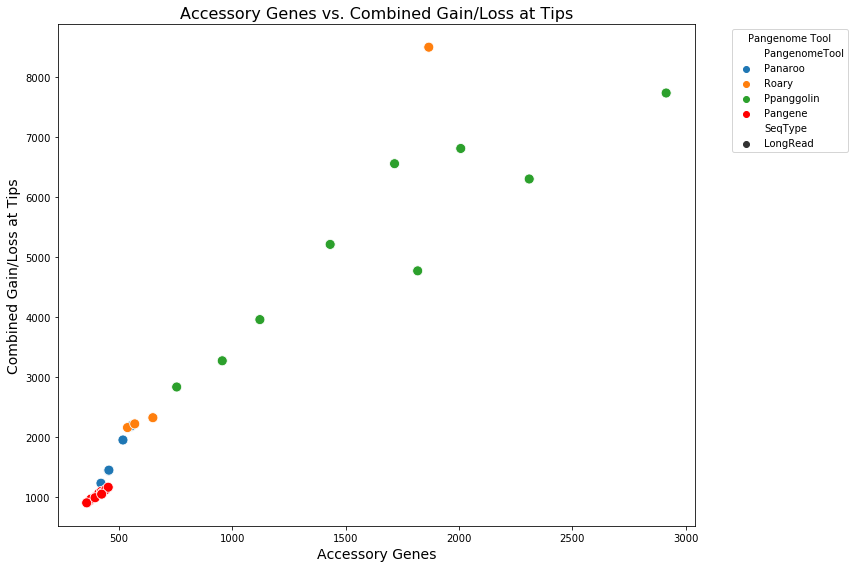

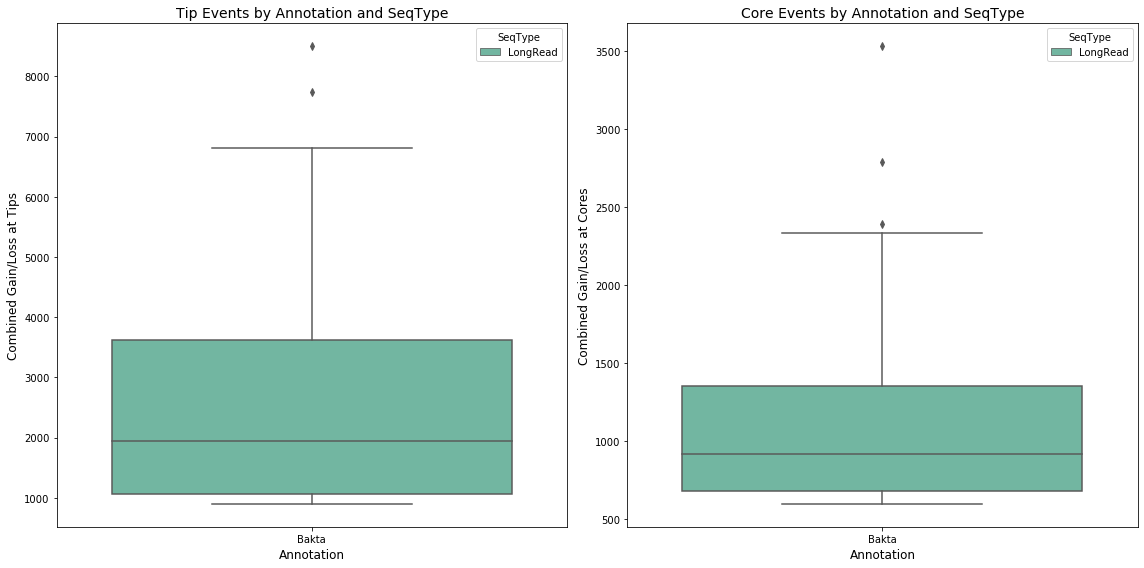

In [67]:
processed_df = PG_WideSumm_V2_DF.query("SeqType == 'LongRead' & Annotation == 'Bakta' ")

# Step 1: Summarize data for tools, annotation, and sequencing technology
summary_stats = processed_df.groupby(["PangenomeTool", "SeqType", "Annotation"]).agg({
    "Accessory genes": ["mean", "median", "std"],
    "Core genes": ["mean", "median", "std"],
    "Total genes": ["mean", "median", "std"],
    "N_Events_Tips": ["mean", "median", "std", "sum"],
    "N_Events_Ancs": ["mean", "median", "std", "sum"]
}).reset_index()

# Flatten the MultiIndex columns
summary_stats.columns = [
    "PangenomeTool", "SeqType", "Annotation",
    "Accessory_Mean", "Accessory_Median", "Accessory_Std",
    "Core_Mean", "Core_Median", "Core_Std",
    "Total_Mean", "Total_Median", "Total_Std",
    "Tips_Mean", "Tips_Median", "Tips_Std", "Tips_Sum",
    "Cores_Mean", "Cores_Median", "Cores_Std", "Cores_Sum"
]

# Step 2: Scatter plot of accessory genes vs. combined events at tips and cores
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(
    x=processed_df["Accessory genes"], y=processed_df["N_Events_Tips"],
    hue=processed_df["PangenomeTool"], style=processed_df["SeqType"],
    palette=Tools_hue_Color_Dict, s=100, ax=ax
)
ax.set_title("Accessory Genes vs. Combined Gain/Loss at Tips", fontsize=16)
ax.set_xlabel("Accessory Genes", fontsize=14)
ax.set_ylabel("Combined Gain/Loss at Tips", fontsize=14)
ax.legend(title="Pangenome Tool", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Step 3: Boxplot comparison by annotation and sequencing technology
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.boxplot(
    x="Annotation", y="N_Events_Tips", hue="SeqType",
    data=processed_df, palette="Set2", ax=axes[0]
)
axes[0].set_title("Tip Events by Annotation and SeqType", fontsize=14)
axes[0].set_ylabel("Combined Gain/Loss at Tips", fontsize=12)
axes[0].set_xlabel("Annotation", fontsize=12)

sns.boxplot(
    x="Annotation", y="N_Events_Ancs", hue="SeqType",
    data=processed_df, palette="Set2", ax=axes[1]
)
axes[1].set_title("Core Events by Annotation and SeqType", fontsize=14)
axes[1].set_ylabel("Combined Gain/Loss at Cores", fontsize=12)
axes[1].set_xlabel("Annotation", fontsize=12)

plt.tight_layout()
plt.show()


## Divide Pan-genome summary stats by "assembly type" and "gene category"

In [68]:
PG_Merged_Stats_LRandSR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ")
PG_Merged_Stats_LRandSR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ")
PG_Merged_Stats_LRandSR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ")

In [69]:
PG_Merged_Stats_LR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'LongRead'  ")

In [86]:
PG_Merged_Stats_SR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'ShortRead'  ")
PG_Merged_Stats_SR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'ShortRead'  ")
PG_Merged_Stats_SR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'ShortRead'  ")

In [70]:
PG_Merged_Stats_LRandSR_Acc_DF.head(2)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
5,Accessory genes,(0% <= strains < 99%),421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,207,475,485,743,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),455,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,262,500,637,800,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


# Viz Explore - V2

In [71]:
#PG_Merged_Stats_LRandSR_Acc_DF.head(4)

In [72]:
Tools_hue_Color_Dict = {"Panaroo": "#1f77b4",
                        "Roary": "#ff7f0e",
                        "Ppanggolin": "#2ca02c" ,
                        "Pangene": "red" }

Panaroo_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Panaroo"], label='Panaroo')
Roary_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Roary"], label='Roary')
Ppanggolin_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Ppanggolin"], label='Ppanggolin')
Pangene_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Pangene"], label='Pangene')

ToolPatches_List = [Panaroo_patch, Roary_patch, Ppanggolin_patch, Pangene_patch]



hue_Order_Tools = ["Panaroo", "Roary", "Ppanggolin", "Pangene"]
Order_AnnoAndType = ['Bakta-LongRead', 'PGAP-LongRead', 'Bakta-ShortRead', 'PGAP-ShortRead']


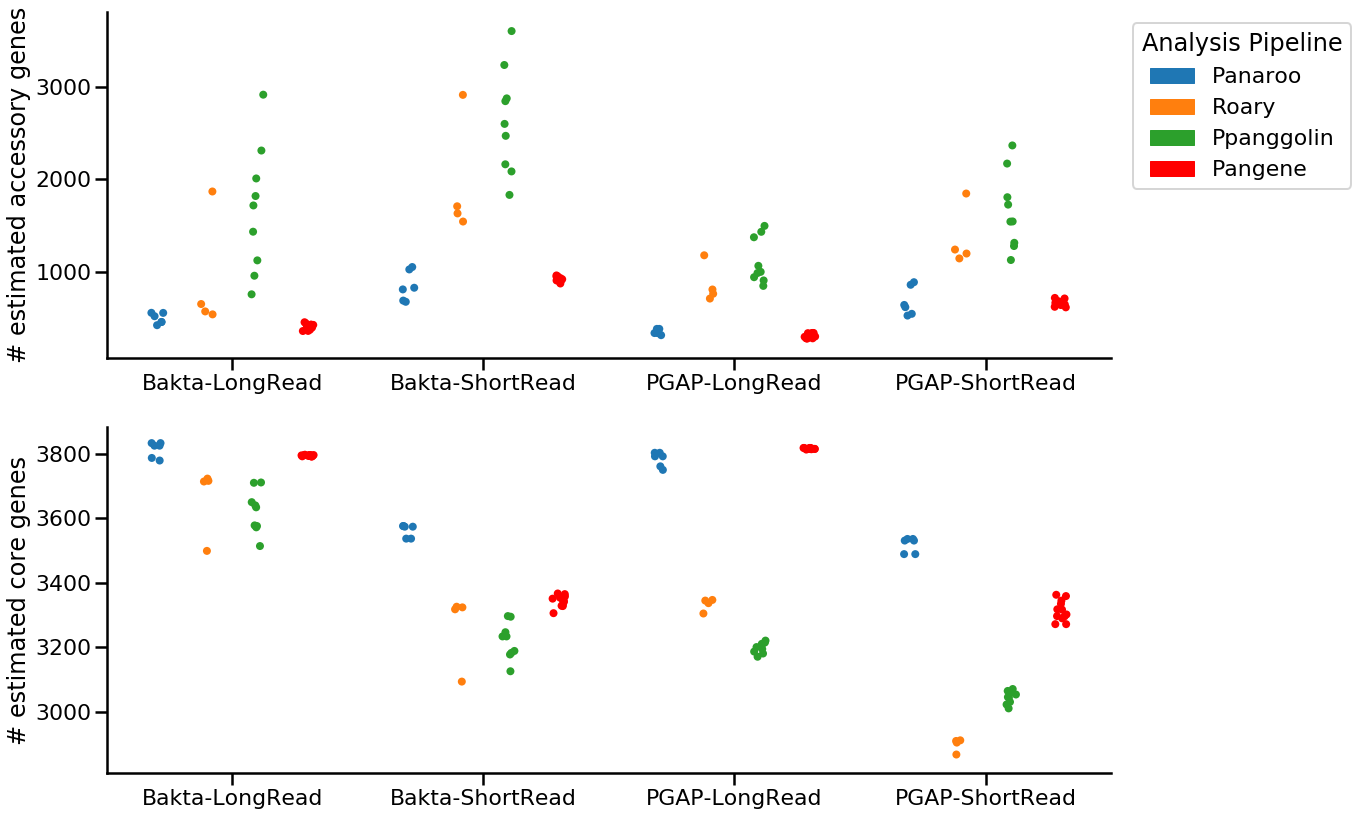

In [73]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Acc_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
#             hue_order = hue_Order_Tools,
#             #order = Order_AnnoAndType,
#             ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Core_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
#             hue_order = hue_Order_Tools, #order = Order_AnnoAndType,
#             ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

sns.despine()

plt.show()

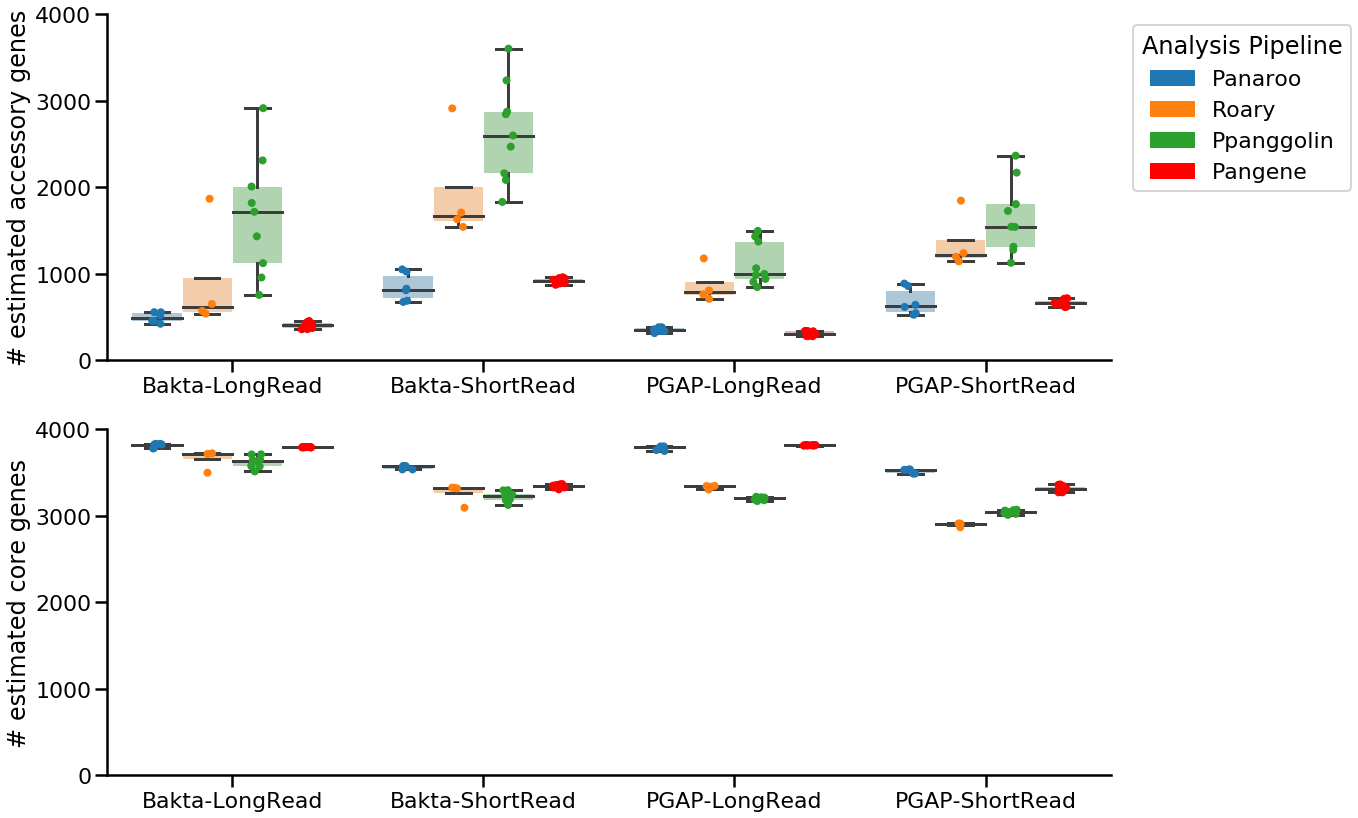

In [74]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Acc_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
            data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
            hue_order = hue_Order_Tools,
            #order = Order_AnnoAndType,
            ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Core_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
            data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
            hue_order = hue_Order_Tools, #order = Order_AnnoAndType,
            ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

axs[0].set_ylim(0, 4000)
axs[1].set_ylim(0, 4000)

sns.despine()

plt.show()

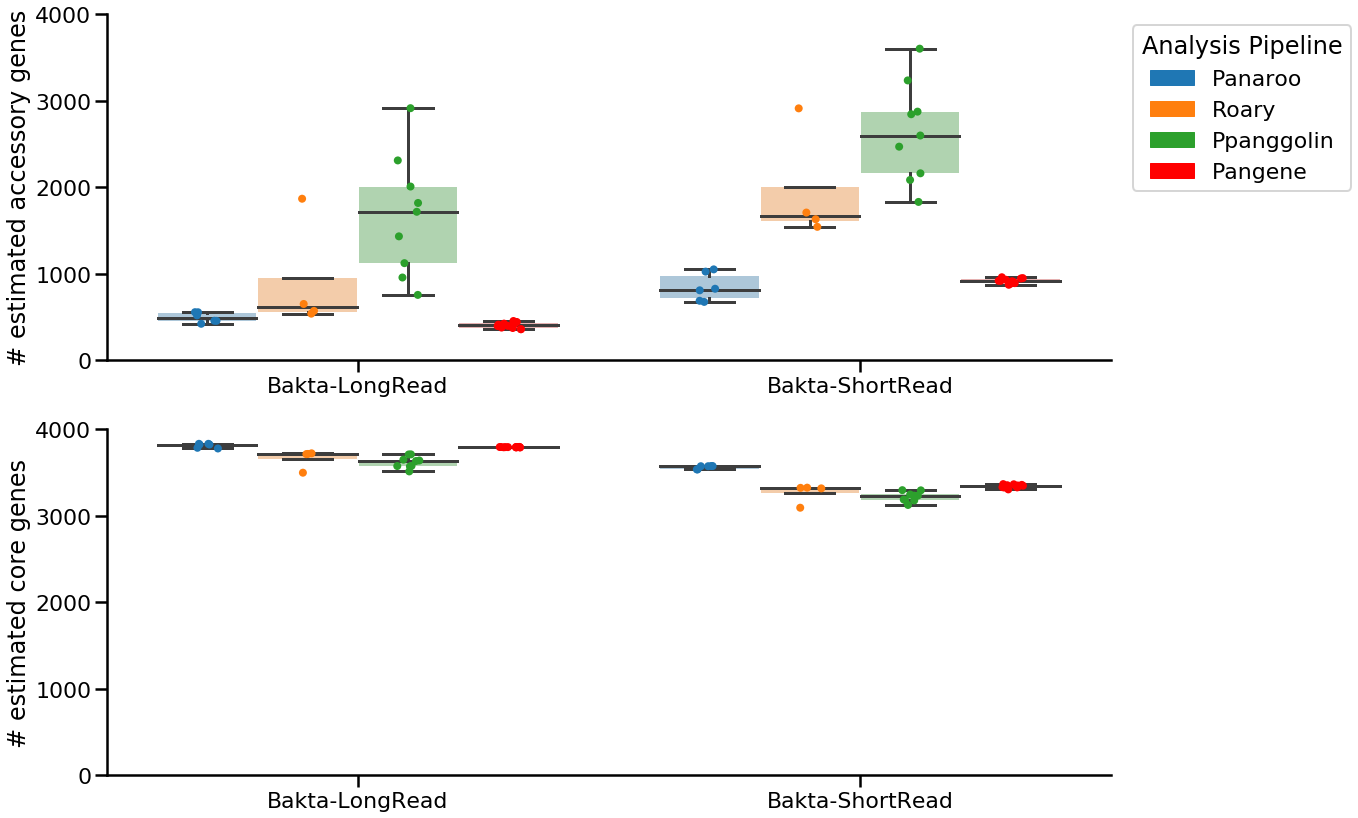

In [75]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Acc_DF.query("Annotation == 'Bakta' "), linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
            data = PG_Merged_Stats_LRandSR_Acc_DF.query("Annotation == 'Bakta' "), fliersize=0,
            hue_order = hue_Order_Tools,
            #order = Order_AnnoAndType,
            ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Core_DF.query("Annotation == 'Bakta' "), linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
            data = PG_Merged_Stats_LRandSR_Core_DF.query("Annotation == 'Bakta' "), fliersize=0,
            hue_order = hue_Order_Tools, #order = Order_AnnoAndType,
            ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

axs[0].set_ylim(0, 4000)
axs[1].set_ylim(0, 4000)

sns.despine()

plt.show()

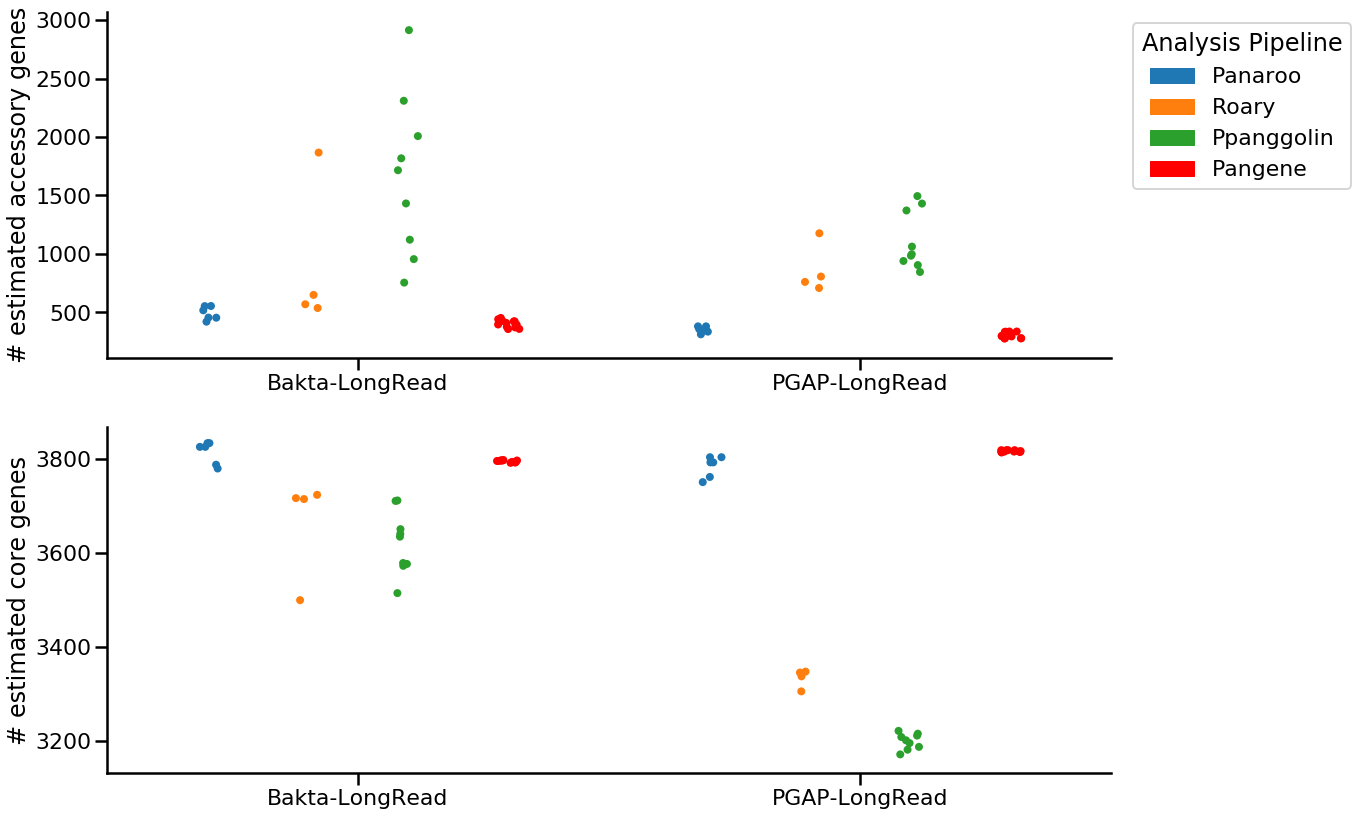

In [87]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LR_Acc_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
#             hue_order = hue_Order_Tools,
#             #order = Order_AnnoAndType,
#             ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LR_Core_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
#             hue_order = hue_Order_Tools, #order = Order_AnnoAndType,
#             ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

sns.despine()

plt.show()

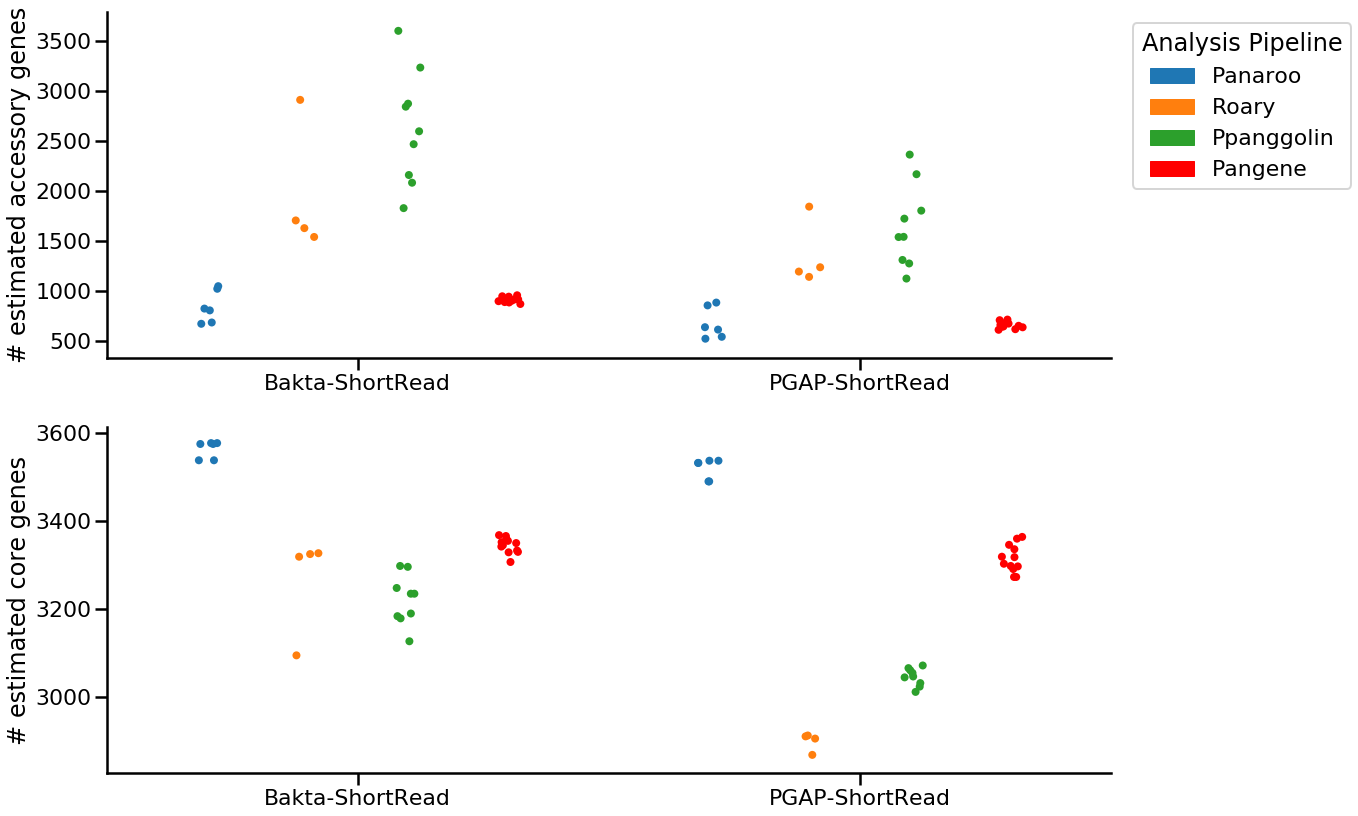

In [88]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_SR_Acc_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_SR_Core_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])


axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

sns.despine()

plt.show()

In [77]:
PG_Merged_Stats_LR_Core_DF.head(1)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_Gain_Ancs,N_Loss_Ancs,N_Gain_Tips,N_Loss_Tips,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
0,Core genes,(99% <= strains <= 100%),3779,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,207,475,485,743,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


# Viz results coloring by Anno-AsmType combinations

In [78]:
AnnoAndTech_hue_Color_BaktaOnly_Dict = {"Bakta-LongRead": "#1f77b4",
                                        "Bakta-ShortRead": "#ff7f0e", }


AnnoAndTech_hue_Color_Dict = { "Bakta-LongRead": "#1f77b4",
                               "PGAP-LongRead": "#2ca02c",
                               "Bakta-ShortRead": "#ff7f0e",
                               "PGAP-ShortRead": "#9467bd" }

Bakta_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-LongRead"],
                                     label='Bakta & Complete Assemblies (N=151)')
Bakta_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-ShortRead"],
                                   label='Bakta & Short-Read Assemblies (N=151)')
PGAP_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["PGAP-LongRead"],
                                    label='PGAP & Complete Assemblies (N=151)')
PGAP_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["PGAP-ShortRead"],
                                  label='PGAP & Short-Read Assemblies (N=151)')

AnnoAndTech_Patches = [Bakta_CompAsm_patch, PGAP_CompAsm_patch, Bakta_SRAsm_patch, PGAP_SRAsm_patch]

AnnoAndTech_BaktaOnly_Patches = [Bakta_CompAsm_patch, Bakta_SRAsm_patch]

hue_orderToPlot_V2 = ["Bakta-LongRead",  "PGAP-LongRead", "Bakta-ShortRead", "PGAP-ShortRead"]

#hue_orderToPlot_X = AnnoAndTech_hue_Color_Dict.keys()
#pallete_ForPlot = AnnoAndTech_hue_Color_Dict.values()


In [79]:
hue_orderToPlot_V2

['Bakta-LongRead', 'PGAP-LongRead', 'Bakta-ShortRead', 'PGAP-ShortRead']

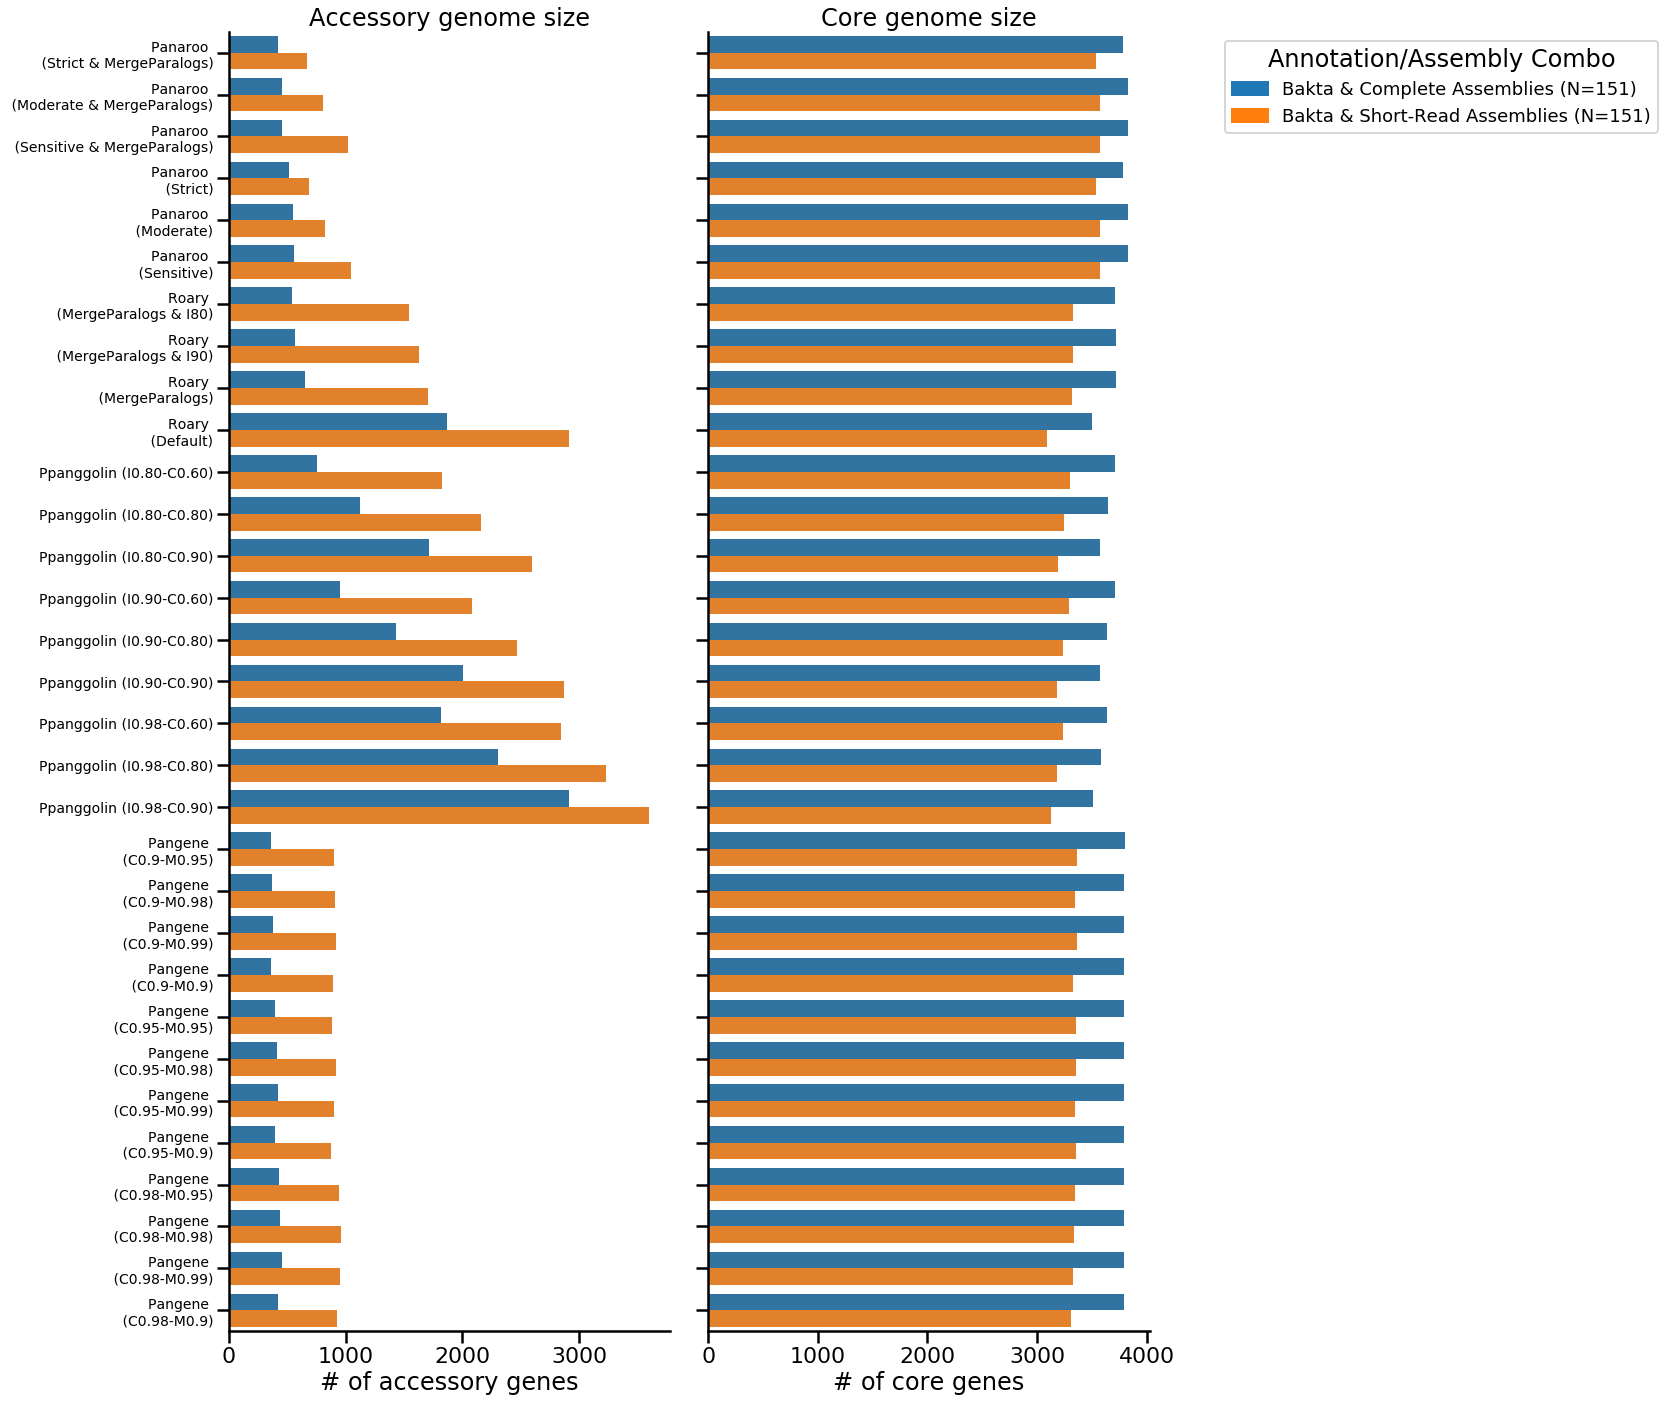

In [80]:
# Change the subplot configuration to 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(24, 20), sharex=False, sharey=True)
sns.set_context("poster")

hue_orderToPlot_X = AnnoAndTech_hue_Color_BaktaOnly_Dict.keys()
pallete_ForPlot = AnnoAndTech_hue_Color_BaktaOnly_Dict.values()


# Plotting on the first and second subplot
sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Acc_DF.query("Annotation == 'Bakta' "),
            order=PipeName_WiParam_List, hue_order=hue_orderToPlot_X, ax=axs[0], palette=pallete_ForPlot)

sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Core_DF.query("Annotation == 'Bakta' "),
            order=PipeName_WiParam_List, hue_order=hue_orderToPlot_X, ax=axs[1], palette=pallete_ForPlot)


# Set labels
axs[0].set_ylabel("") # Adjust as needed
axs[1].set_ylabel("") # Adjust as needed
axs[0].set_xlabel("# of accessory genes", rotation=0)
axs[1].set_xlabel("# of core genes", rotation=0)

# Set tick labels
for i_ax in axs:
    i_ax.set_yticklabels(labels=PGCombos_TickLabels, rotation=0, fontdict={"fontsize": 14})

axs[1].legend(title = "Annotation/Assembly Combo",
              handles = AnnoAndTech_BaktaOnly_Patches,
              bbox_to_anchor=(1.15, 1),
              fontsize= 18) 

axs[0].get_legend().remove(), 

# Set titles
axs[0].set_title("Accessory genome size")
axs[1].set_title("Core genome size")

# Despine and layout adjustment
sns.despine()
plt.tight_layout()

plt.show()

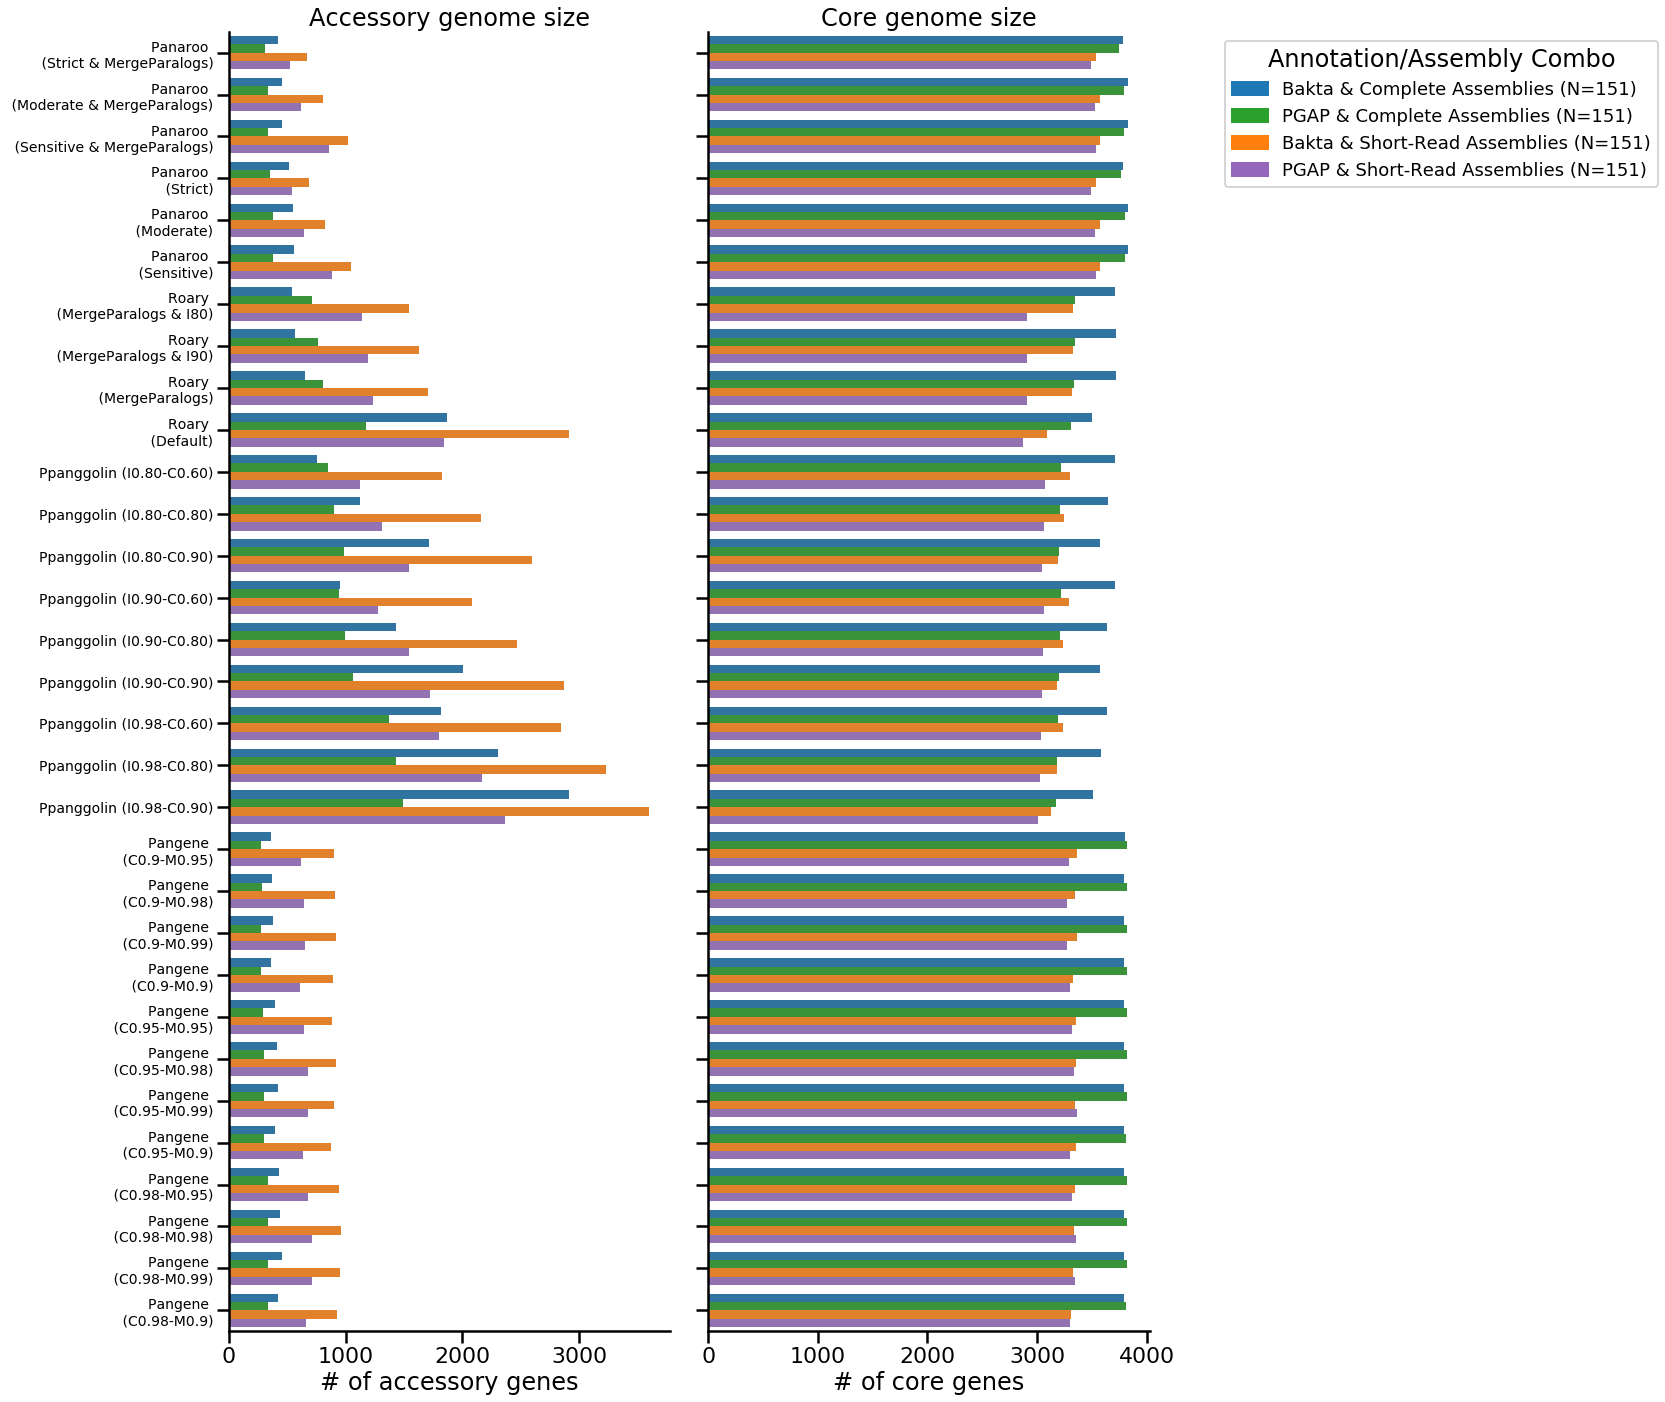

In [81]:
# Change the subplot configuration to 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(24, 20), sharex=False, sharey=True)
sns.set_context("poster")

hue_orderToPlot_X = AnnoAndTech_hue_Color_Dict.keys()
pallete_ForPlot = AnnoAndTech_hue_Color_Dict.values()

# Plotting on the first and second subplot
sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Acc_DF,
            order=PipeName_WiParam_List, hue_order=hue_orderToPlot_V2, ax=axs[0], palette=pallete_ForPlot)

sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Core_DF,
            order=PipeName_WiParam_List, hue_order=hue_orderToPlot_V2, ax=axs[1], palette=pallete_ForPlot)

# Set labels
axs[0].set_ylabel("") # Adjust as needed
axs[1].set_ylabel("") # Adjust as needed
axs[0].set_xlabel("# of accessory genes", rotation=0)
axs[1].set_xlabel("# of core genes", rotation=0)

# Set tick labels
for i_ax in axs:
    i_ax.set_yticklabels(labels=PGCombos_TickLabels, rotation=0, fontdict={"fontsize": 14})

axs[1].legend(title = "Annotation/Assembly Combo", handles = AnnoAndTech_Patches,
              bbox_to_anchor=(1.15, 1), fontsize= 18) 
axs[0].get_legend().remove(), 

# Set titles
axs[0].set_title("Accessory genome size")
axs[1].set_title("Core genome size")

# Despine and layout adjustment
sns.despine()
plt.tight_layout()

#plt.savefig("Results3_Plots/3.PG.Counts.SRvsLR.AND.BaktaVsPGAP.CombinedCoreAccPlots.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Results3_Plots/3.PG.Counts.SRvsLR.AND.BaktaVsPGAP.CombinedCoreAccPlots.svg", bbox_inches="tight")

plt.show()

In [82]:
# Calculate correlation between N_Gain_Tips and Accessory genes (GeneCount for Accessory genes)

# Filter the dataframe for accessory genes
accessory_genes_df = PG_Merged_Stats_LRandSR_DF[PG_Merged_Stats_LRandSR_DF['Category'] == 'Accessory genes']

# Extract relevant columns for correlation
correlation_data = accessory_genes_df[['GeneCount', 'N_Gain_Tips']]

# Drop any rows with missing values
correlation_data = correlation_data.dropna()

# Calculate the correlation
correlation = correlation_data.corr().loc['GeneCount', 'N_Gain_Tips']
correlation


0.8880453941118516

KeyError: "['N_Gain_Cores'] not in index"

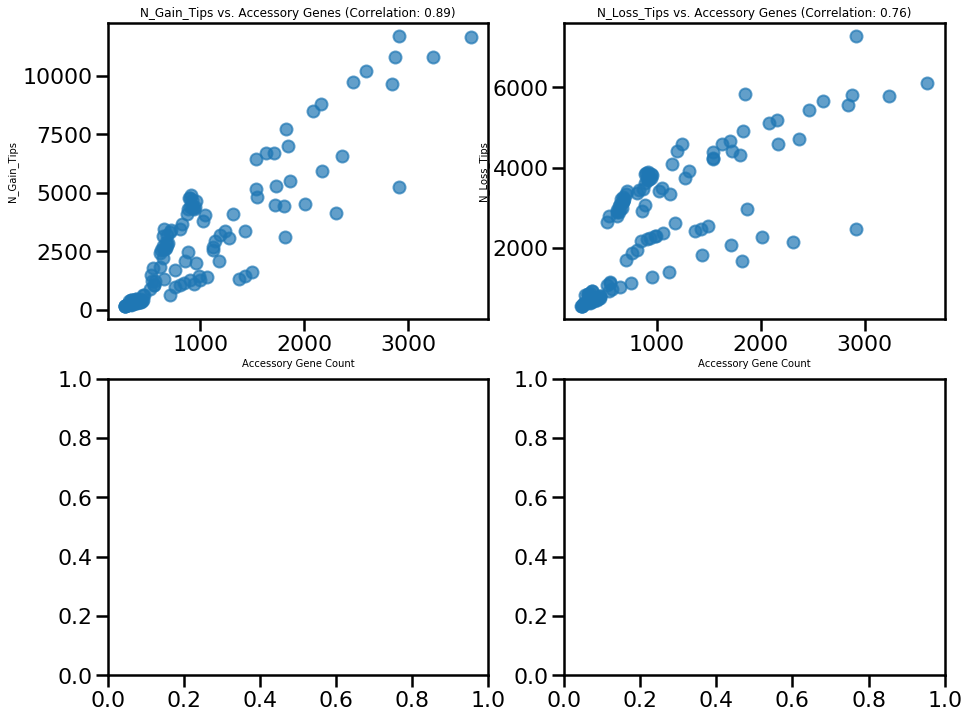

In [83]:

# Scatter plots and correlation calculations for various comparisons
metrics = ['N_Gain_Tips', 'N_Loss_Tips', 'N_Gain_Cores', 'N_Loss_Cores']
correlations = {}

# Plot configuration
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    # Calculate correlation
    correlation = accessory_genes_df[['GeneCount', metric]].dropna().corr().loc['GeneCount', metric]
    correlations[metric] = correlation
    
    # Scatter plot
    axes[i].scatter(accessory_genes_df['GeneCount'], accessory_genes_df[metric], alpha=0.7)
    axes[i].set_title(f'{metric} vs. Accessory Genes (Correlation: {correlation:.2f})', fontsize=12)
    axes[i].set_xlabel('Accessory Gene Count', fontsize=10)
    axes[i].set_ylabel(metric, fontsize=10)

sns.despine()
plt.tight_layout()
plt.show()

correlations


In [ ]:
accessory_genes_df["SeqType"].value_counts()  

In [ ]:
accessory_genes_df["Annotation"].value_counts()   

In [ ]:
accessory_genes_df[["Annotation", "SeqType"]].value_counts()